In [1]:
# %load setup.py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Calibration [![Generic badge](https://img.shields.io/badge/MS19-Section4-purple?logo=read-the-docs)](https://doi.org/10.1093/restud/rdy030)


In this notebook, we will calibrate the parameters based on U.S data between 2001 and 2019.

We will fetch the data from FRED. To do this, we will use the `fredapi` package. 

In [2]:
from fredapi import Fred
# API key needs to be taken out when deployed
fred = Fred(api_key='30adf5295a539a48e57fe367896a60e9')

Our calibration period goes from 2001 to 2019.

In [3]:
start_date = '2001-01-01'
end_date = '2019-12-31'

## Calibration of $s$

$s$ is the job separation rate. We will calibrate it as the average value of the US separation data over our sample period. 

In [4]:
s_ts = fred.get_series('JTSTSR', frequency='q', observation_start=start_date, observation_end=end_date)

Here is what the U.S job separation rate looks like over our sample period.

<AxesSubplot:title={'center':'U.S Job Separation Rate between 2001 and 2019'}>

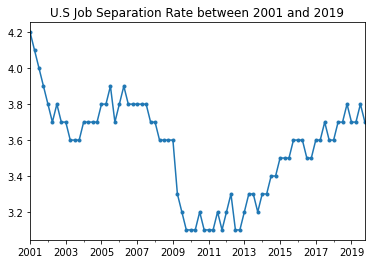

In [5]:
s_ts.plot(title="U.S Job Separation Rate between 2001 and 2019", marker='.')

We can now calibrate $s$ for our model:

In [6]:
s = s_ts.mean()
s

3.5578947368421048

## Calibration of $\bar{u}$

We now calibrate $\bar{u}$, which is the steady-state unemployment rate. We calibrate it as the average value of the US unemployment rate over our sample period.

In [7]:
u_ts = fred.get_series('UNRATE', frequency='q', observation_start=start_date, observation_end=end_date)

This is what unemployment rate in the U.S looks like over our sample period:

<AxesSubplot:title={'center':'U.S Unemployment Rate between 2001 and 2019'}>

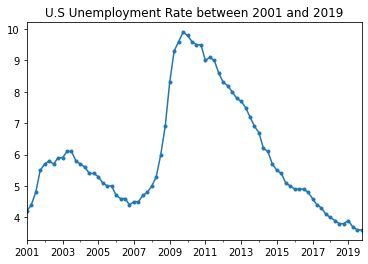

In [8]:
u_ts.plot(title="U.S Unemployment Rate between 2001 and 2019", marker='.')

Taking the average gives us the calibrated value of $\bar{u}$:

In [9]:
u_bar = u_ts.mean()
u_bar

5.9750000000000005

## Calibration of $\bar{x}$

We will now claibrate $\bar{x}$, which is the steady-state labor market tightness. We will calibrate it as the average value of the US labor market tightness over our sample period.

Note that labor market tightness is defined as:

$$x(t) = \frac{v(t)}{k-Y(t)},$$

where $v$ denotes the vacancy level, $k$ the productive capacity of households, and $Y$ output. Therefore, $k - Y(t)$ is simply the unemployment level, since output comes from services provided by households. 

In [10]:
v_ts = fred.get_series('JTSJOL', frequency='q', observation_start=start_date, observation_end=end_date)
ul_ts = fred.get_series('UNEMPLOY', frequency='q', observation_start=start_date, observation_end=end_date)
x_ts = v_ts/ul_ts

Here is what the labor market tightness looks like over our sample period.

<AxesSubplot:title={'center':'U.S Labor Market Tightness between 2001 and 2019'}>

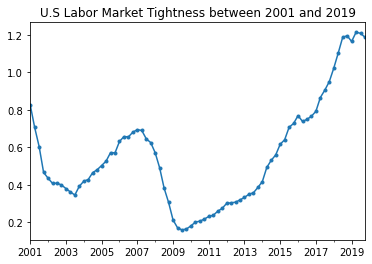

In [11]:
x_ts.plot(title="U.S Labor Market Tightness between 2001 and 2019", marker='.')

We can now calculate the steady-state labor market tightness $\bar{x}$:

In [12]:
x_bar = x_ts.mean()
x_bar

0.557752047505985

## Calibration of $\overline{G/C}$

$\overline{G/C}$ is the steady-state ratio between public and private employment. We will calibrate it as the average value of the ratio between public and private employment in the U.S over our sample period. 

In [13]:
G_ts = fred.get_series('USGOVT', frequency='q', observation_start=start_date, observation_end=end_date)
C_ts = fred.get_series('USPRIV', frequency='q', observation_start=start_date, observation_end=end_date)
GC_ts = G_ts/C_ts

This is what the ratio between public and private employment looks like over our sample period:

<AxesSubplot:title={'center':'U.S Public to Private Employment Ratio between 2001 and 2019'}>

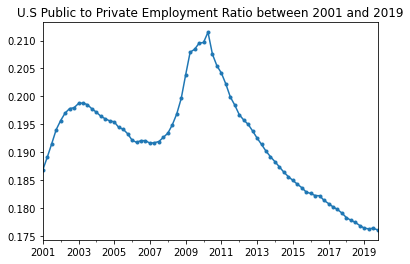

In [14]:
GC_ts.plot(title="U.S Public to Private Employment Ratio between 2001 and 2019", marker='.')

We now calibrate the steady-state ratio $\overline{G/C}$

In [15]:
GC_bar = GC_ts.mean()
GC_bar

0.19191729280673472

## Calibration of $\bar{M}$ 

The parameter $\bar{M}$ is the average unemployment multiplier, which is the same as the output multiplier. The unemployment multiplier is estimated by measuring the percentage-point change in the unemployment rate when public expenditure increases by $1\%$ of GDP. 

Monacelli et al. ([2010](http://dx.doi.org/10.1016/j.jmoneco.2010.05.009), pp. 533–536) estimate a structural vector autoregression (SVAR) on U.S. data and find unemployment multipliers between $0.2$ and $0.6$. Ramey ([2013](http://doi.org/10.7208/chicago/9780226018584.003.0002), pp.40–42) estimates SVARs on U.S. data with various identification schemes and sample periods and finds unemployment multipliers between $0.2$ and $0.5$, except in one specification where the multiplier is $1$.

The multiplier entering our formula could be larger if multipliers are larger when unemployment is higher, as suggested by recent research on state-dependent multipliers. For instance, estimating regime-switching SVARs on U.S. data, Auerbach and Gorodnichenko ([2012](http://doi.org/10.1257/pol.4.2.1), table 1) find that while the output multiplier is $0.6$ in expansions and $1$ on average, it is as high as $2.5$ in recessions.

Thus, we will use a range of unemployment multipliers with lower bound $0$, upper bound $2$, and median $1$.

In [16]:
M_bar_h, M_bar_m, M_bar_l = 2, 1, 0

## Calibration of $\epsilon$

The parameter $\epsilon$ is the elasticity of substitution between public and private consumption. Amano and Wirjanto ([1997](https://doi.org/10.1162/003465397557187), [1998](https://doi.org/10.1006/redy.1998.0021)) estimate the elasticity of substitution between public and private consumption to be 0.9 and 1.56. Here, we consider three values: $\epsilon = 0.5, \epsilon = 1$ and $\epsilon = 1.5.$ You can also play with the parameter values of $\epsilon$.

In [17]:
epsilon_h, epsilon_m, epsilon_l = 1.5, 1, 0.5

# Calculating Optimal Stimulus

We will calculate optimal stimulus with the following equation:

                $\frac{g/c - (g/c)^*}{(g/c)^*} \approx \frac{z_0 \epsilon m}{1 + z_1 z_0\epsilon m^2}\cdot \frac{u_0 - u^*}{u^*}$          [![Generic badge](https://img.shields.io/badge/MS19-Eq23-purple?logo=read-the-docs)](https://doi.org/10.1093/restud/rdy030)  

